In [1]:
import numpy as np
import numpy.linalg as la
import os
from ctypes import c_int, c_double, POINTER, cdll
from tqdm import tqdm

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize': (8, 6)})

In [2]:
# Release dll if loaded
dll = None
# Compile cuda code and load dll
os.system("pwsh ./run.ps1 > log")
dll = cdll.LoadLibrary("./build/Release/kernel.dll")
## Define function signatures
# # void call_qpe_kernel(double* data, int nAll, int T, int R, bool unbiased)
# dll.call_qpe_kernel.argtypes = [POINTER(c_double), c_int, c_int, c_int, c_int]
# # void call_oqae_kernel(double* data, int nAll, int T)
# dll.call_oqae_kernel.argtypes = [POINTER(c_double), c_int, c_int]
# void call_mlae_kernel(double* data, int nAll, int length, int* Ms, int* Rs, double eta, int precision)
dll.call_mlae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), POINTER(c_int), c_double, c_int]
# void call_rqae_kernel(double* data, int nAll, int length, int* Ms, double eta, int precision)
dll.call_rqae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), c_double, c_int]

In [3]:
nSample = 1024
eta = 0.995
a_ls = np.linspace(0, 1, 300)

In [4]:
def get_fi_single_degree(a_arr, deg, eta):
    td_sq = (1 - 2 * np.sin(deg * np.arcsin(np.sqrt(a_arr)))**2) ** 2
    return (deg ** 2 * (eta ** (2 * deg)) * (1 - td_sq)) / (a_arr * (1 - a_arr) * (1 - (eta ** (2 * deg)) * td_sq))

Pointwise analysis of MLAE

In [5]:
bias_MLAE = np.zeros_like(a_ls)
errs_MLAE = np.zeros(len(a_ls))
CRLB_MLAE = np.zeros_like(a_ls)
R0_RQAE = 32
K_MLAE = 5

# sample cdf for length points
Ms = np.array([((1 << i) | 1) for i in range(K_MLAE)], dtype=np.int32)
Rs = np.ones(K_MLAE, dtype=np.int32) * R0_RQAE
cost = Ms.sum()*R0_RQAE
CRLB_MLAE = sum([get_fi_single_degree(a_ls, Ms[i], eta) * Rs[i] for i in range(K_MLAE)]) ** -0.5
print(f"Ms: {Ms} R:{R0_RQAE} Cost: {cost}")

src = np.repeat(a_ls, nSample)
res = np.copy(src)
dll.call_mlae_kernel(
    res.ctypes.data_as(POINTER(c_double)),
    len(a_ls) * nSample,
    K_MLAE,
    Ms.ctypes.data_as(POINTER(c_int)),
    Rs.ctypes.data_as(POINTER(c_int)),
    eta,
    10000
)

for idx, a in enumerate(a_ls):
    bias = np.mean(res[idx * nSample:(idx + 1) * nSample]) - a
    bias_MLAE[idx] = bias
    err = la.norm(res[idx * nSample:(idx + 1) * nSample] - a) / np.sqrt(nSample)
    errs_MLAE[idx] = err

C:\Users\hello\AppData\Local\Temp\ipykernel_14960\3833109103.py:3: RuntimeWarning: invalid value encountered in divide
  return (deg ** 2 * (eta ** (2 * deg)) * (1 - td_sq)) / (a_arr * (1 - a_arr) * (1 - (eta ** (2 * deg)) * td_sq))


Ms: [ 1  3  5  9 17] R:32 Cost: 1120


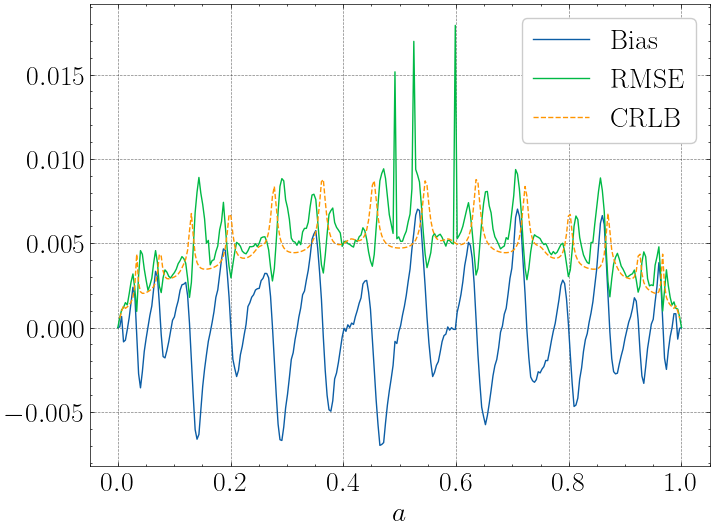

In [10]:
plt.figure()
plt.plot(a_ls, bias_MLAE, label='Bias', color='C0')
plt.plot(a_ls, errs_MLAE, label='RMSE', color='C1')
plt.plot(a_ls, CRLB_MLAE, label='CRLB', color='C2', linestyle='--')
plt.xlabel('$a$')
plt.legend()
plt.savefig('bias_mlae_noisy.pdf')
plt.show()

Pointwise analysis of RQAE

In [7]:
bias_RQAE = np.zeros_like(a_ls)
errs_RQAE = np.zeros(len(a_ls))
CRLB_RQAE = np.zeros_like(a_ls)
R0_RQAE = 32
D_RQAE = 32

cdf = np.cumsum(1 / np.arange(1, D_RQAE+1))
R_RQAE = round(R0_RQAE * cdf[-1])
cdf /= cdf[-1]  # normalize to 1
# sample cdf for length points
Ms = np.array([np.searchsorted(cdf, np.random.random()) + 1 for i in range(R_RQAE)], dtype=np.int32)
cost = Ms.sum()
CRLB_RQAE = sum([get_fi_single_degree(a_ls, Ms[i], eta) for i in range(R_RQAE)]) ** -0.5
print(f"Ms: {Ms} R:{R_RQAE} Cost: {cost}")

src = np.repeat(a_ls, nSample)
res = np.copy(src)
dll.call_rqae_kernel(
    res.ctypes.data_as(POINTER(c_double)),
    nSample*len(a_ls),
    R_RQAE,
    Ms.ctypes.data_as(POINTER(c_int)),
    eta,
    10000
)

for idx, a in enumerate(a_ls):
    bias = np.mean(res[idx * nSample:(idx + 1) * nSample]) - a
    bias_RQAE[idx] = bias
    err = la.norm(res[idx * nSample:(idx + 1) * nSample] - a) / np.sqrt(nSample)
    errs_RQAE[idx] = err

C:\Users\hello\AppData\Local\Temp\ipykernel_14960\3833109103.py:3: RuntimeWarning: invalid value encountered in divide
  return (deg ** 2 * (eta ** (2 * deg)) * (1 - td_sq)) / (a_arr * (1 - a_arr) * (1 - (eta ** (2 * deg)) * td_sq))


Ms: [ 1  1  1 10 12  1  8  1 19  9 14  1 17  9 13 20  8  2  2 13 12 18  5  5
 26  1 26 28  1 11  3  5  1  1  4  5  1  1  2  1  3  1  1 22 11 31 17 15
 21 14  9  9  8  1  8  4  1  4 17 13  1 10  1  1 16  1  1 17 32  3  9  2
  2  5  1  9 15  4  1  3 20  4  2  5 10  2 10  1  6  9  6  7  4 25 20  3
 26 13  1  5  3 10  1  7  9  1  7  1  2  1  4  1 11 11  3  1  6 18  5  5
  1  4  1  7  7  1  5 26  1 23] R:130 Cost: 1025


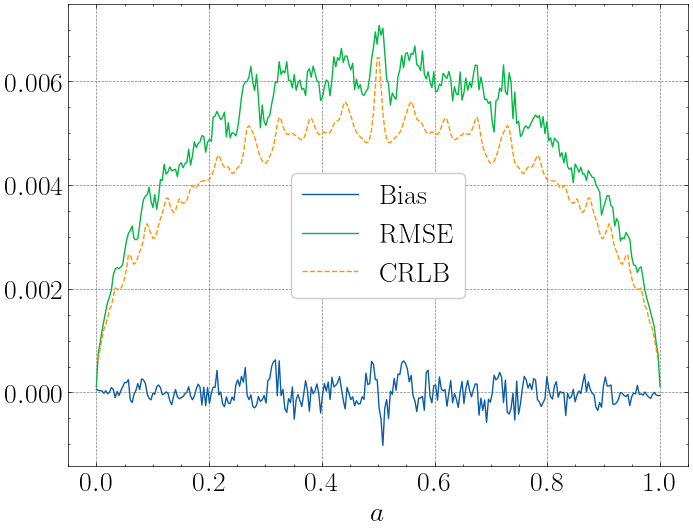

In [9]:
plt.figure()
plt.plot(a_ls, bias_RQAE, label='Bias', color='C0')
plt.plot(a_ls, errs_RQAE, label='RMSE', color='C1')
plt.plot(a_ls, CRLB_RQAE, label='CRLB', color='C2', linestyle='--')
plt.xlabel('$a$')
plt.legend()
plt.savefig('bias_rqae_noisy.pdf')
plt.show()